必要パッケージのインストール

In [4]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 21.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 21.0 MB/s eta 0:00:00m eta 0:00:010:00:01


In [2]:
from typing import Union

import numpy as np
import scipy

# 実空間一様グリッドの定義

In [3]:
xmin = -10
xmax = 10
Ngrid = 100
x_g = np.linspace(xmin, xmax, Ngrid)
dx = x_g[1] - x_g[0]
dx

0.20202020202020243

# ポテンシャルの定義
調和振動子 $V_{ext}(x)=(1/2)m\omega^2x^2, \omega=1$とする

In [4]:
def V_ext(x: Union[np.array, float]):
    return 0.5 * x**2

# 電子間ポテンシャルの定義
クーロン相互作用は1/|x1-x2|。ゼロ割の処理としてとりあえず大きい数字(1e7)に置き換える。

In [51]:
def V_ee(x1: float, x2: float):
    if abs(x1 - x2) < 1e-7:
        return 1e7
    return 1.0 / abs(x2 - x1)

# 2体版_ハミルトニアン行列の定義
- 差分法にて∇^2を表現する。
- スピンレス系とする
- 1番目の粒子の座標をx_g2, 2番目の粒子の座標をx_g2として、G=g1*Ngrid+g2  をインデックスに持つサイズNgrid^2の配列として波動関数を離散化する。

In [45]:
H2 = np.zeros((Ngrid**2, Ngrid**2))
kin_diag = -0.5 * (-2.0 / dx**2)
kin_offdiag = -0.5 * (1.0 / dx**2)
for g1 in range(Ngrid):
    x1 = x_g[g1]
    v1 = V_ext(x1)
    for g2 in range(Ngrid):
        G = g1 * Ngrid + g2
        x2 = x_g[g2]
        v2 = V_ext(x2)
        vint = V_ee(x1, x2)
        H2[G, g1 * Ngrid + g2] = 2 * kin_diag + v1 + v2 + vint
        if g2 > 0:
            H2[G, g1 * Ngrid + g2 - 1] = kin_offdiag
        if g1 > 0:
            H2[G, (g1 - 1) * Ngrid + g2] = kin_offdiag
        if g2 < Ngrid - 1:
            H2[G, g1 * Ngrid + g2 + 1] = kin_offdiag
        if g1 < Ngrid - 1:
            H2[G, (g1 + 1) * Ngrid + g2] = kin_offdiag
print(H2)

from scipy.sparse import csr_matrix

H2_csr = csr_matrix(H2)

[[ 1.00001490e+07 -1.22512500e+01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.22512500e+01  1.51955204e+02 -1.22512500e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.22512500e+01  1.47521220e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.47521220e+02
  -1.22512500e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.22512500e+01
   1.51955204e+02 -1.22512500e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.22512500e+01  1.00001490e+07]]


# scipyの疎行列ライブラリを使って対角化

In [46]:
%%time
es_i, psis_gi = scipy.sparse.linalg.eigsh(H2_csr, k=10, which="SM")
psis_ig = psis_gi.T
print(es_i[0])

2.7230571939694603
CPU times: user 1min 19s, sys: 2.85 s, total: 1min 22s
Wall time: 15.1 s


# 基底状態の電子密度の計算

In [47]:
n2b = np.zeros(Ngrid)
for g1 in range(Ngrid):
    for g2 in range(Ngrid):
        n2b[g1] += psis_ig[0, g1 * Ngrid + g2] ** 2 * dx
n2b_tot = np.sum(n2b) * dx
print(n2b_tot)
n2b = n2b / n2b_tot * 2.0  # 規格化、電子数2個

0.04081216202428389


# 電子密度のプロット

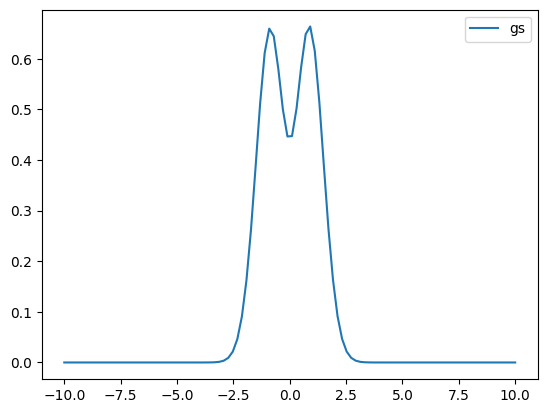

In [48]:
from matplotlib import pyplot as plt

plt.plot(x_g, n2b, label="2b")
plt.legend()

# 1電子状態との比較
1体の基底状態と第一励起状態に電子を配置した電子密度と比較してみる。

In [49]:
# 1体ハミルトニアンを解く

H = np.zeros((Ngrid, Ngrid))
kin_diag = -0.5 * (-2.0 / dx**2)
kin_offdiag = -0.5 * (1.0 / dx**2)
for g in range(Ngrid):
    H[g, g] = kin_diag + V_ext(x_g[g])
    if g > 0:
        H[g, g - 1] = kin_offdiag
    if g < Ngrid - 1:
        H[g, g + 1] = kin_offdiag


H_csr = csr_matrix(H)  # Compressed Sparse Row matrix
es_i, psis_gi = scipy.sparse.linalg.eigsh(H_csr, k=10, which="SM")
psis_ig = psis_gi.T

# 電子密度計算
n1b = psis_ig[0] ** 2 + psis_ig[1] ** 2
n1b_tot = n1b.sum() * dx
n1b = n1b / n1b_tot * 2.0

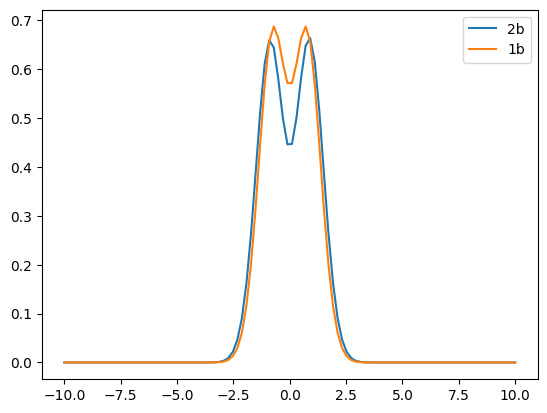

In [50]:
from matplotlib import pyplot as plt

plt.plot(x_g, n2b, label="2b")
plt.plot(x_g, n1b, label="1b")
plt.legend()

## (Optional)
- 疎行列ライブラリで対角化するとどうなるか(非常に重く、数分がかかるので注意。スペックによってはフリーズする可能性あり。)
- なぜ、n2bとn1bの形は似るのか。